In [1061]:
import pandas as pd 
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt

In [1062]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
print(device)

mps


## 1. Importing the dataset

In [1063]:
# Importing the dataset from CSV file
df = pd.read_csv('dataset.csv', index_col=0)

In [1064]:
# Preview the dataset
df

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
2020-03-02,5314.009766,1.10,1.10,97.360001,33.419998,0.0
2020-03-03,5138.990234,0.93,1.02,97.150002,36.820000,391.0
2020-03-04,5367.529785,0.71,1.02,97.339996,31.990000,200.0
2020-03-05,5197.419922,0.61,0.92,96.820000,39.619999,0.0
2020-03-06,5086.419922,0.45,0.74,95.949997,41.939999,46.0
...,...,...,...,...,...,...
2024-02-23,10265.709961,5.26,4.26,103.940002,13.750000,133.0
2024-02-26,10329.919922,5.26,4.28,103.830002,13.740000,1639.0
2024-02-27,10347.509766,5.25,4.31,103.830002,13.430000,1529.0
2024-02-28,10257.580078,5.24,4.27,103.980003,13.840000,1099.0


In [1065]:
# Drop rows where column value is '.'
df = df[(df['short_term_rates'] != '.') & (df['short_term_rates'] != '.')]

In [1066]:
# Convert interest rate columns to float 32
df['short_term_rates'] = df['short_term_rates'].astype('float32')
df['long_term_rates'] = df['long_term_rates'].astype('float32')

/var/folders/fm/jxt3g9_s4ps7mv9cq1d2f2h80000gn/T/ipykernel_52426/873558200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_term_rates'] = df['short_term_rates'].astype('float32')
/var/folders/fm/jxt3g9_s4ps7mv9cq1d2f2h80000gn/T/ipykernel_52426/873558200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long_term_rates'] = df['long_term_rates'].astype('float32')


In [1067]:
train_set_percentage = 0.9
train_df = df.iloc[:int(len(df)*train_set_percentage)]
test_df = df.iloc[int(len(df)*train_set_percentage):]

In [1068]:
# Scaling the training data
scaler = MinMaxScaler(feature_range=(-1,1))

train_df_scaled = scaler.fit_transform(train_df.to_numpy())
train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)

In [1069]:
scaler_prices = MinMaxScaler(feature_range=(-1,1))
scaler_prices.fit(train_df[['nasdaq_t100']].to_numpy())

MinMaxScaler(feature_range=(-1, 1))

In [1070]:
test_df_scaled = scaler.transform(test_df.to_numpy())
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)

## 2. Pre-processing the Data

In [1071]:
def split_data(stock, lookback):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    x = data[:,:-1,:]
    y = data[:,-1,:1]
    
    return [x,y]

In [1072]:
lookback = 10
x_train, y_train = split_data(train_df_scaled.values.astype('float32'), lookback)
x_test, y_test = split_data(test_df_scaled.values.astype('float32'), lookback)

In [1073]:
# Convert the arrays to torch tensors and move them to GPU
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [1074]:
x_train.shape

torch.Size([890, 9, 6])

In [1075]:
y_train.shape

torch.Size([890, 1])

### 3. Declaring the Model

In [1076]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size) -> None:
        super(LSTM, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [1077]:
# Initializing the model
def initialize_and_train_LSTM(input_size:int, hidden_size: int, num_layers:int, num_epochs:int, lr:float, seed:int) -> None:
  torch.manual_seed(42)
  model = LSTM(input_size, hidden_size=hidden_size, num_layers = num_layers, output_size=1).to(device)

  # Declaring the loss function: Mean squared error(MSE) loss
  criterion = nn.MSELoss(reduction='mean')

  # Declaring the optimizer: Adam
  optimizer = torch.optim.Adam(model.parameters(), lr)

  losses = []
  # Run the training
  for epoch in range(num_epochs):
    # Calculate loss from the output via forward pass
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)

    # Perform Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Update learning rate for all parameters
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())
  

  plt.plot(losses)
  plt.title('Training Loss vs Epochs')
  plt.ylabel('Training Loss')
  plt.xlabel('Epochs')
  plt.grid(True)
  plt.show()
  return model

Epoch [1/4000], Loss: 0.1759
Epoch [2/4000], Loss: 0.3524
Epoch [3/4000], Loss: 0.1680
Epoch [4/4000], Loss: 0.1792
Epoch [5/4000], Loss: 0.1555
Epoch [6/4000], Loss: 0.1217
Epoch [7/4000], Loss: 0.0766
Epoch [8/4000], Loss: 0.0951
Epoch [9/4000], Loss: 0.0804
Epoch [10/4000], Loss: 0.0936
Epoch [11/4000], Loss: 0.0544
Epoch [12/4000], Loss: 0.0244
Epoch [13/4000], Loss: 0.0233
Epoch [14/4000], Loss: 0.0294
Epoch [15/4000], Loss: 0.0378
Epoch [16/4000], Loss: 0.0266
Epoch [17/4000], Loss: 0.0304
Epoch [18/4000], Loss: 0.0251
Epoch [19/4000], Loss: 0.0260
Epoch [20/4000], Loss: 0.0248
Epoch [21/4000], Loss: 0.0177
Epoch [22/4000], Loss: 0.0153
Epoch [23/4000], Loss: 0.0131
Epoch [24/4000], Loss: 0.0138
Epoch [25/4000], Loss: 0.0163
Epoch [26/4000], Loss: 0.0138
Epoch [27/4000], Loss: 0.0102
Epoch [28/4000], Loss: 0.0114
Epoch [29/4000], Loss: 0.0125
Epoch [30/4000], Loss: 0.0103
Epoch [31/4000], Loss: 0.0084
Epoch [32/4000], Loss: 0.0073
Epoch [33/4000], Loss: 0.0071
Epoch [34/4000], Lo

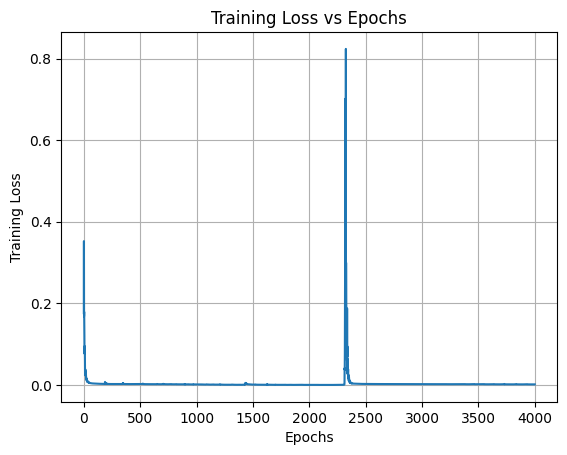

In [1078]:
model = initialize_and_train_LSTM(6, 128, 2, 4000, 0.01, 42)

## Evaluation

### 1. On Training Set

In [1079]:
# Function to calculate MAPE from torch tensors
def calculate_mape(preds, target):
  mape = torchmetrics.MeanAbsolutePercentageError()
  mape.update(preds, target)
  return mape.compute()

In [1080]:
# Put model into evaluation mode
model.eval()

# Disable gradient tracking during inference
with torch.no_grad():
    # Evaluate the model for test data and apply classification threshold
    y_train_pred = model(x_train)

# Reverse the min-max transformation
y_train_pred = scaler_prices.inverse_transform(y_train_pred.to('cpu'))
y_train = scaler_prices.inverse_transform(y_train.to('cpu'))

# Evaluating MAPE for training set
print("Train set MAPE:")
print(calculate_mape(torch.from_numpy(y_train_pred), torch.from_numpy(y_train)).numpy()*100)

Train set MAPE:
1.0869849473237991


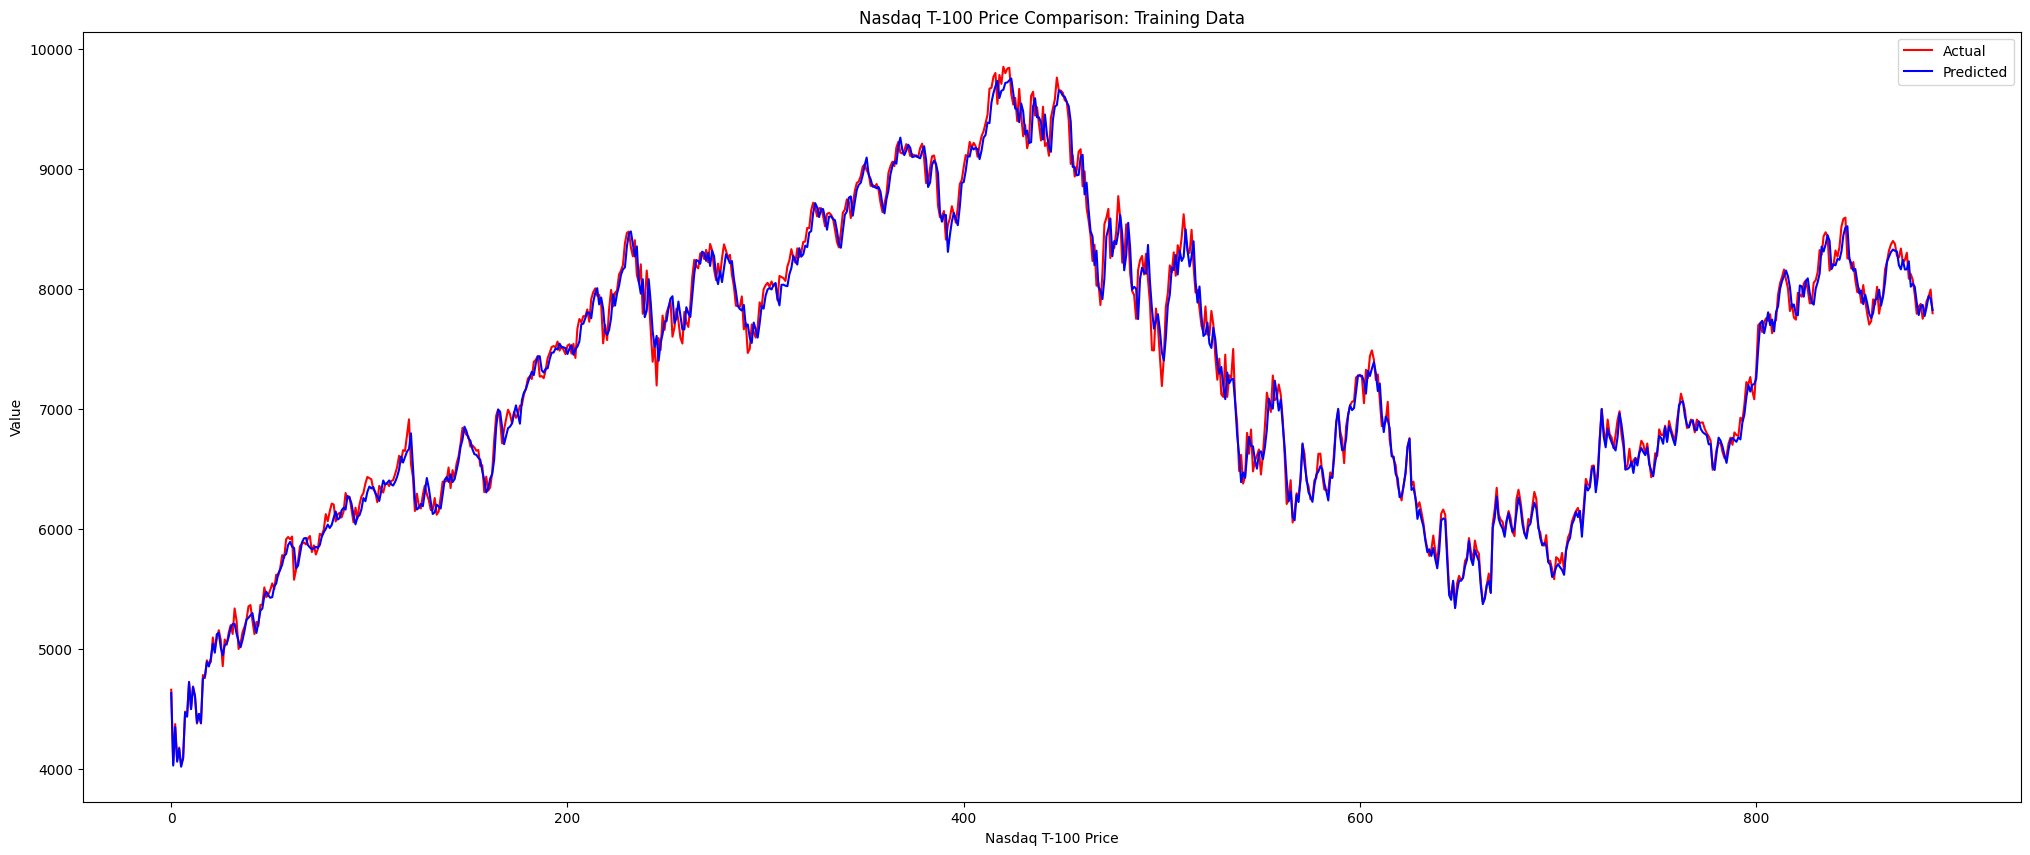

In [1081]:
# Plot the data
plt.figure(figsize=(25,10))
plt.plot(y_train, label="Actual", color="red")
plt.plot(y_train_pred, label="Predicted", color="blue")

# Add labels and title (optional)
plt.xlabel("Nasdaq T-100 Price")
plt.ylabel("Value")
plt.title("Nasdaq T-100 Price Comparison: Training Data")
plt.legend()

### 2. On Test set

In [1082]:
model.eval()

# Disable gradient tracking during inference
with torch.no_grad():
    # Evaluate the model for test data and apply classification threshold
    y_test_pred = model(x_test)

# Reverse the min-max transformation
#y_test_pred = np.exp(scaler_prices.inverse_transform(y_test_pred.to('cpu')))
#y_test = np.exp(scaler_prices.inverse_transform(y_test))
y_test_pred = scaler_prices.inverse_transform(y_test_pred.to('cpu'))
y_test = scaler_prices.inverse_transform(y_test)


# Evaluating MAPE for test set
print("Test Set MAPE")
print(calculate_mape(torch.from_numpy(y_test_pred), torch.from_numpy(y_test)).numpy()*100)

Test Set MAPE
2.1902550011873245


In [1083]:
y_test_pred.shape

(90, 1)

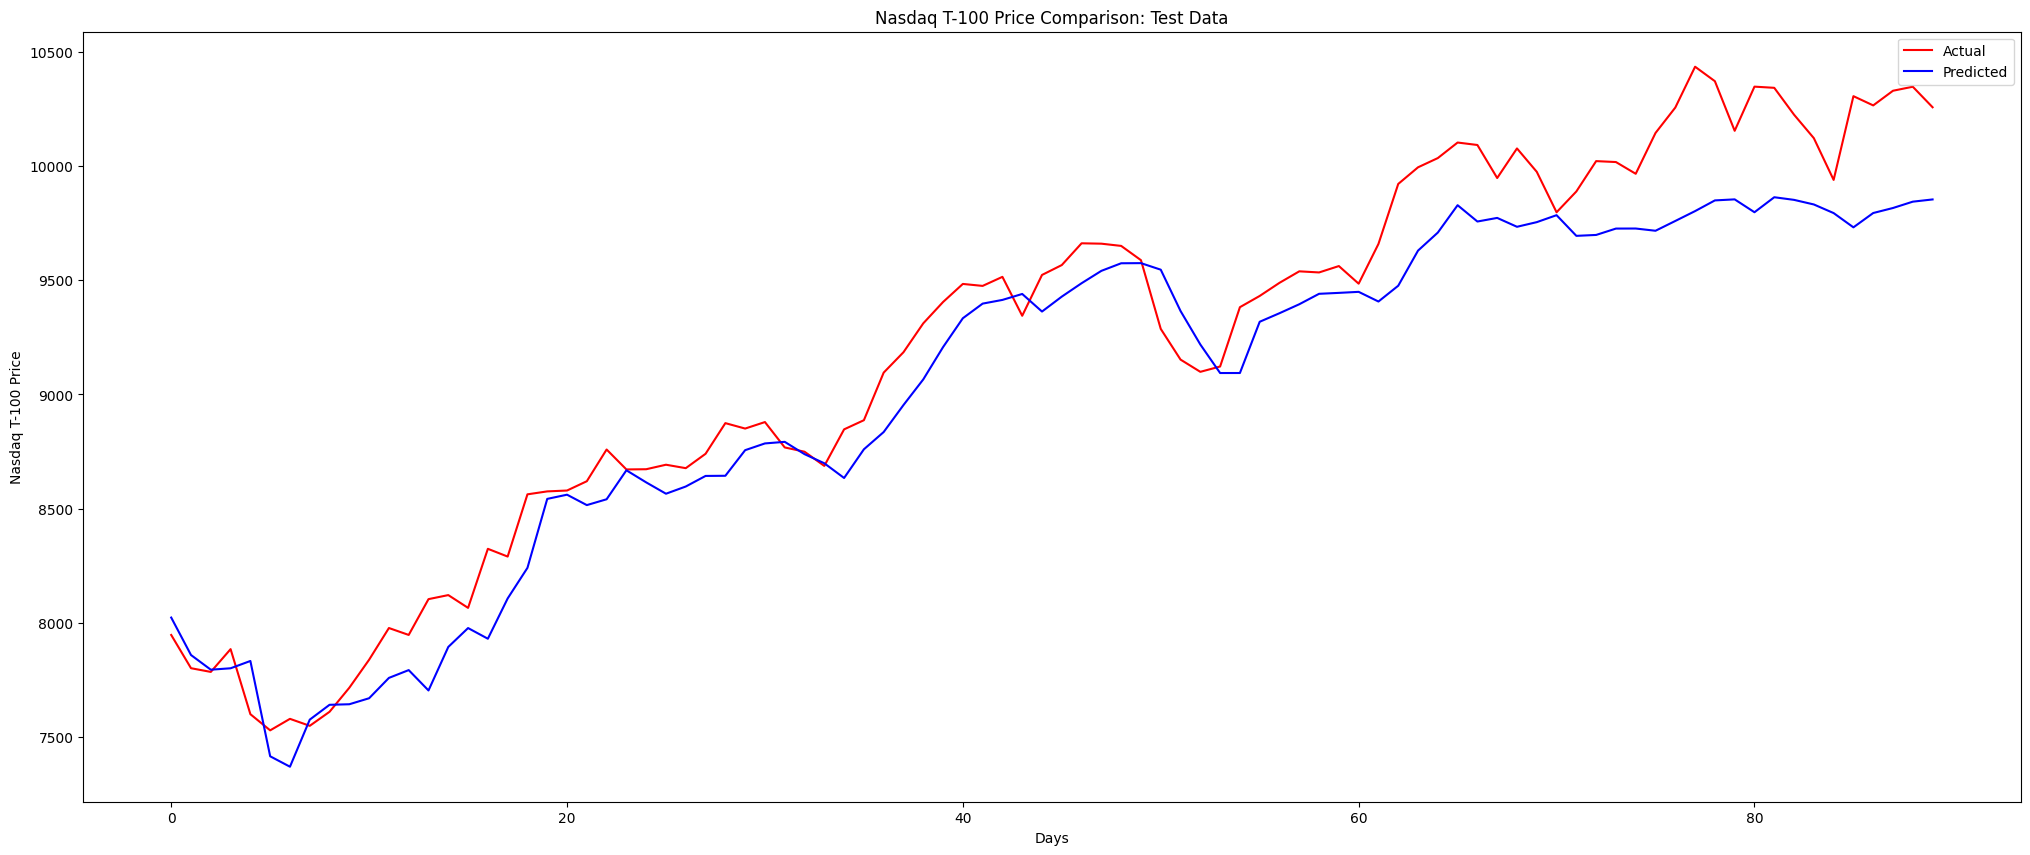

In [1084]:
# Plot the data
plt.figure(figsize=(25,10))
plt.plot(y_test, label="Actual", color="red")
plt.plot(y_test_pred, label="Predicted", color="blue")

# Add labels and title (optional)
plt.xlabel("Days")
plt.ylabel("Nasdaq T-100 Price")
plt.title("Nasdaq T-100 Price Comparison: Test Data")
plt.legend()

## Scenario Simulation and Prediction

In [1085]:
def prepare_test_set_for_model(test_sc_df):
    test_sc_df_scaled = scaler.transform(test_sc_df.to_numpy())
    test_sc_df_scaled = pd.DataFrame(test_sc_df_scaled, columns=test_df.columns)
    x_sc, y_sc = split_data(test_sc_df_scaled.values.astype('float32'), lookback)

    # Convert the arrays to torch tensors and move them to GPU
    return torch.from_numpy(x_sc).type(torch.Tensor).to(device)

In [1086]:
# Utility function to return predictions for scenario
def evaluate_model_for_scenario(x_sc):
    predictions = []
    model.eval()
    for i in range(x_sc.shape[0]):
        # Disable gradient tracking during inference
        with torch.no_grad():
            # Evaluate the model for test data and apply classification threshold
            y_sc_pred = model(x_sc[i:i+1, :, :])
            
            # Update value for next look-back
            if i < x_sc.shape[0]:
                x_sc[i+1:i+2, -1, 0] = y_sc_pred

            # Save the prediction
            predictions.append(scaler_prices.inverse_transform(y_sc_pred.to('cpu'))[0])    

    # Reverse the min-max transformation
    #y_test_pred = np.exp(scaler_prices.inverse_transform(y_test_pred.to('cpu')))
    #y_test = np.exp(scaler_prices.inverse_transform(y_test))
    return predictions

### 1. Fed hikes interest rates by 0.5 basis points

In [1087]:
test_df_sc1 = test_df.copy()
test_df_sc1["short_term_rates"] = test_df_sc1["short_term_rates"] + 0.5
test_df_sc1.describe()

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9111.939282,5.759900,4.308600,104.063000,14.520300,868.720000
std,873.847271,0.040113,0.315934,1.483191,2.386517,1345.072287
min,7528.819824,5.700000,3.790000,100.989998,12.070000,0.000000
25%,8282.362305,5.730000,4.067500,103.229998,12.927500,185.000000
50%,9235.855469,5.750000,4.255000,103.930000,13.705000,453.500000
75%,9941.469727,5.780000,4.572500,105.300001,14.895000,924.000000
max,10435.120117,5.860000,4.980000,106.879997,21.709999,10346.000000


In [1088]:
x_sc1 = prepare_test_set_for_model(test_df_sc1)
predictions_sc1 = evaluate_model_for_scenario(x_sc1)

### 2. Fed drops interest rates by 0.5 points

In [1089]:
test_df_sc2 = test_df.copy()
test_df_sc2["short_term_rates"] = test_df_sc2["short_term_rates"] - 0.5
test_df_sc2.describe()

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9111.939282,4.759900,4.308600,104.063000,14.520300,868.720000
std,873.847271,0.040113,0.315934,1.483191,2.386517,1345.072287
min,7528.819824,4.700000,3.790000,100.989998,12.070000,0.000000
25%,8282.362305,4.730000,4.067500,103.229998,12.927500,185.000000
50%,9235.855469,4.750000,4.255000,103.930000,13.705000,453.500000
75%,9941.469727,4.780000,4.572500,105.300001,14.895000,924.000000
max,10435.120117,4.860000,4.980000,106.879997,21.709999,10346.000000


In [1090]:
x_sc2 = prepare_test_set_for_model(test_df_sc2)
predictions_sc2 = evaluate_model_for_scenario(x_sc2)

### 3. Change in VIX by 10 points

In [1091]:
test_df_sc3 = test_df.copy()
test_df_sc3["vix_index"] = test_df_sc3["vix_index"] + 10
test_df_sc3.describe()

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9111.939282,5.259900,4.308600,104.063000,24.520300,868.720000
std,873.847271,0.040113,0.315934,1.483191,2.386517,1345.072287
min,7528.819824,5.200000,3.790000,100.989998,22.070000,0.000000
25%,8282.362305,5.230000,4.067500,103.229998,22.927500,185.000000
50%,9235.855469,5.250000,4.255000,103.930000,23.705000,453.500000
75%,9941.469727,5.280000,4.572500,105.300001,24.895000,924.000000
max,10435.120117,5.360000,4.980000,106.879997,31.709999,10346.000000


In [1092]:
x_sc3 = prepare_test_set_for_model(test_df_sc3)
predictions_sc3 = evaluate_model_for_scenario(x_sc3)

### 4. VIX decreases by 10

In [1093]:
test_df_sc4 = test_df.copy()
test_df_sc4["vix_index"] = test_df_sc4["vix_index"] - 10
test_df_sc4.describe()

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9111.939282,5.259900,4.308600,104.063000,4.520300,868.720000
std,873.847271,0.040113,0.315934,1.483191,2.386517,1345.072287
min,7528.819824,5.200000,3.790000,100.989998,2.070000,0.000000
25%,8282.362305,5.230000,4.067500,103.229998,2.927500,185.000000
50%,9235.855469,5.250000,4.255000,103.930000,3.705000,453.500000
75%,9941.469727,5.280000,4.572500,105.300001,4.895000,924.000000
max,10435.120117,5.360000,4.980000,106.879997,11.709999,10346.000000


In [1094]:
x_sc4 = prepare_test_set_for_model(test_df_sc4)
predictions_sc4 = evaluate_model_for_scenario(x_sc4)

### 5. Dollar Index changes by 5%

In [1096]:
test_df_sc5 = test_df.copy()
test_df_sc5["dollar_index"] = test_df_sc5["dollar_index"] * 1.05
test_df_sc5.describe()

,nasdaq_t100,short_term_rates,long_term_rates,dollar_index,vix_index,Laid_Off_Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9111.939282,5.259900,4.308600,109.266150,14.520300,868.720000
std,873.847271,0.040113,0.315934,1.557351,2.386517,1345.072287
min,7528.819824,5.200000,3.790000,106.039498,12.070000,0.000000
25%,8282.362305,5.230000,4.067500,108.391498,12.927500,185.000000
50%,9235.855469,5.250000,4.255000,109.126500,13.705000,453.500000
75%,9941.469727,5.280000,4.572500,110.565001,14.895000,924.000000
max,10435.120117,5.360000,4.980000,112.223997,21.709999,10346.000000


In [1097]:
x_sc5 = prepare_test_set_for_model(test_df_sc5)
predictions_sc5 = evaluate_model_for_scenario(x_sc5)

## Plotting all the scenarios

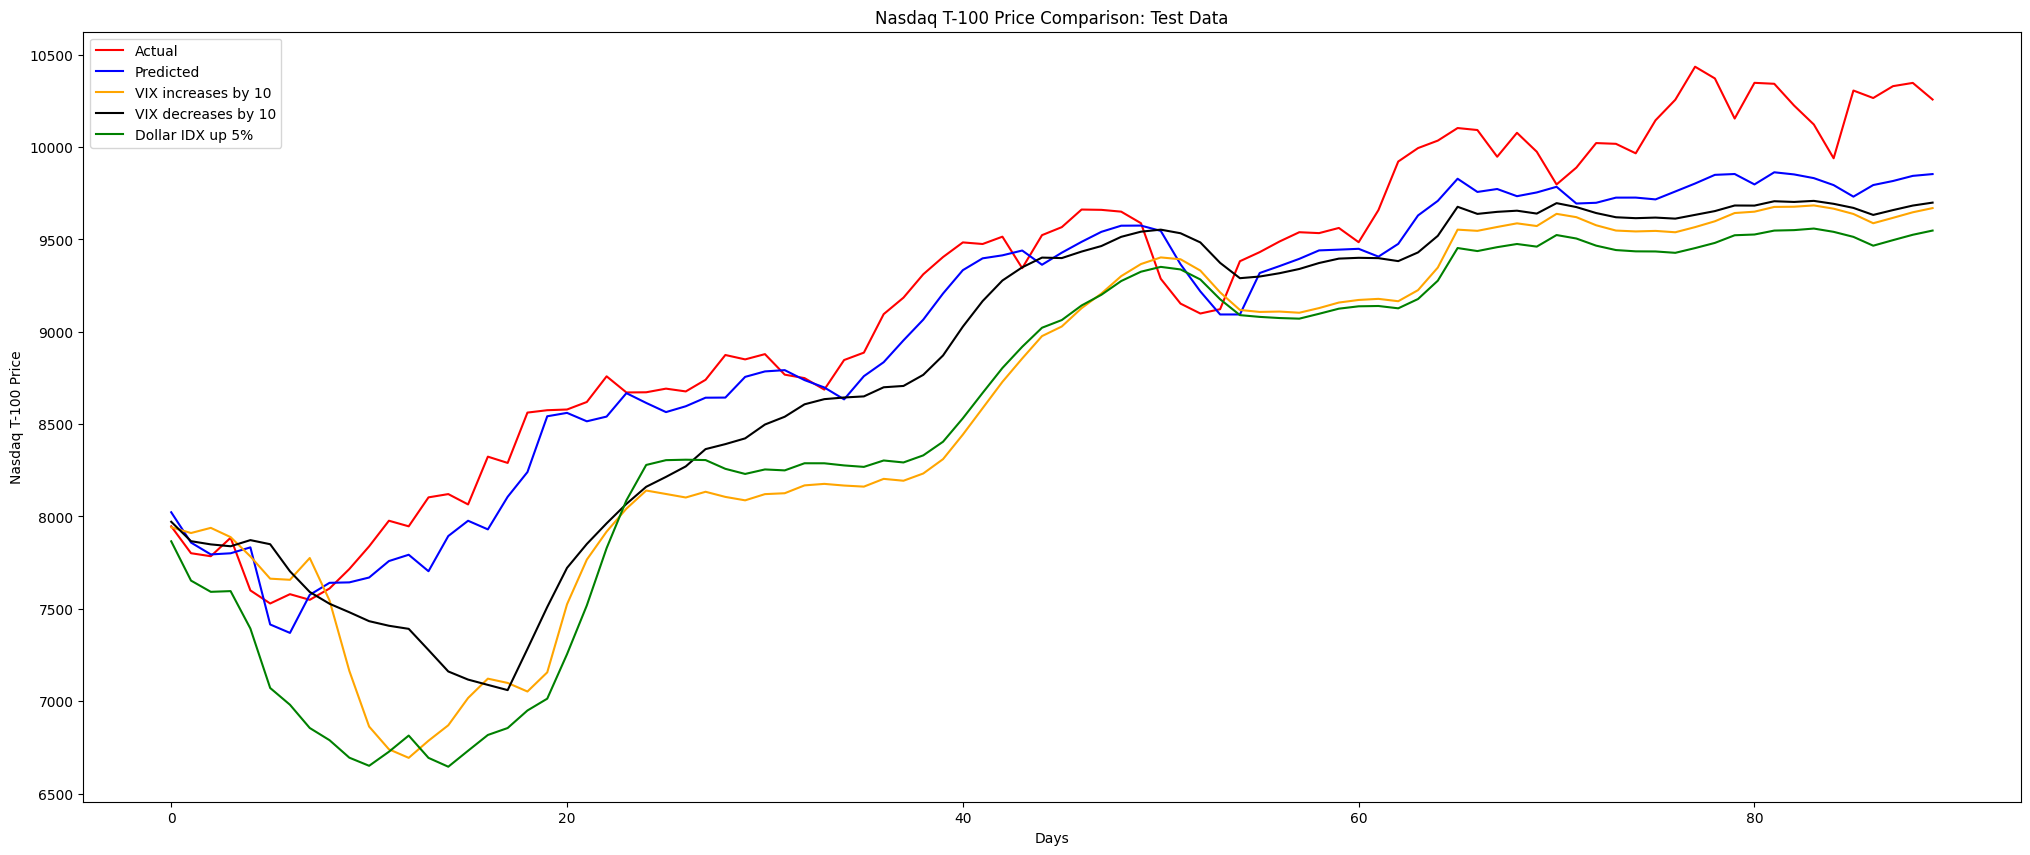

In [1099]:
# Plot the data
plt.figure(figsize=(25,10))
plt.plot(y_test, label="Actual", color="red")
plt.plot(y_test_pred, label="Predicted", color="blue")
#plt.plot(predictions_sc1, label="Interest rate hike", color="black")
#plt.plot(predictions_sc2, label="Interest rate drop", color="pink")
plt.plot(predictions_sc3, label="VIX increases by 10", color="orange")
plt.plot(predictions_sc4, label="VIX decreases by 10", color="black")
plt.plot(predictions_sc5, label="Dollar IDX up 5%", color="green")

# Add labels and title (optional)
plt.xlabel("Days")
plt.ylabel("Nasdaq T-100 Price")
plt.title("Nasdaq T-100 Price Comparison: Test Data")
plt.legend()